# Imports

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

import json
import joblib

# Metrics

In [2]:
def print_metrics(y_train, y_pred_train, y_test, y_pred_test, cv_scores):
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    F1_score_test = f1_score(y_test, y_pred_test)
    
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    F1_score_train = f1_score(y_train, y_pred_train)
    
    metrics = {'Test': [accuracy_test, precision_test, recall_test, F1_score_test], 
               'Train': [accuracy_train, precision_train, recall_train, F1_score_train],
               'CV': [cv_scores['accuracy'], cv_scores['precision'], cv_scores['recall'], cv_scores['f1']]}
    metrics_df = pd.DataFrame(data=metrics, index = ['accuracy', 'precision', 'recall', 'F1'])
    
    return metrics_df

In [3]:
def get_summing_metrics(scores_dict):
    scores = ['accuracy', 'precision', 'recall', 'f1']
    scores_dict = {key: [value[metric] for metric in scores] for key, value in scores_dict.items()}
    
    return pd.DataFrame(data=scores_dict, index=scores)

In [4]:
def plot_confusion_matrix(estimator, X, y, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_title('Confusion Matrix')
    y_pred = estimator.predict(X)
    ConfusionMatrixDisplay.from_predictions(y, y_pred, ax=ax, colorbar=False)
    return ax

def plot_auc_roc_proba(estimator, X, y, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_title('ROC Curve')
    y_pred_proba = estimator.predict_proba(X)[::,1]
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
    roc_auc = roc_auc_score(y, y_pred_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Current estimator').plot(ax=ax)
    ax.plot([0,1], [0,1], 'r--', label='Random guess (AUC = 0.5)')
    ax.legend(loc=4)
    return ax

def plot_precision_recall_curve(estimator, X, y, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_title('Precision-Recall Curve')
    y_pred_proba = estimator.predict_proba(X)[::,1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax)
    return ax

def plot_learning_curve(estimator, X, y, cv, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10), ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_title('Learning Curve')
    ax.set_xlabel("Samples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    ax.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="orange", label="Cross-validation score")
    ax.legend(loc=4)
    return ax

In [5]:
def plot_graphs(estimator, X_train, X_test, y_train, y_test, cv, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

    plot_confusion_matrix(estimator, X_test, y_test, ax=ax1)
    plot_auc_roc_proba(estimator, X_test, y_test, ax=ax2)
    plot_precision_recall_curve(estimator, X_test, y_test, ax=ax3)
    plot_learning_curve(estimator, X_train, y_train, cv, ax=ax4)
    
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])

    ax3.set_xlim([0, 1])
    ax3.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

## Other

In [6]:
def get_cv_scores(estimator, X, y, cv=5):
    scores = ['accuracy', 'precision', 'recall', 'f1']
    cv_scores = {key.lstrip('test_'): np.mean(value) for key, value in cross_validate(estimator, X, y, cv=cv, scoring=scores).items()}
    cv_scores = {key: value for key, value in cv_scores.items() if key in scores}
    return cv_scores

# Dataset

In [7]:
features = ['age', 'month_income', 'employment_length', 'home_ownership', 'loan_intent', 'loan_amount', 'loan_interest_rate', 'previous_loans', 'previous_default', 'loan_grade', 'loan_status']
df = pd.read_csv('./../dataset/credit_history_transformed.csv')
df

,age,month_income,employment_length,home_ownership,loan_intent,loan_amount,loan_interest_rate,previous_loans,previous_default,loan_grade,loan_status
0,-0.921889,-0.129575,-0.189056,-0.897295,0.369470,4.045790,1.626087,-0.689950,2.164001,-1.529191,0
1,-1.084171,-1.449010,0.062600,2.250370,0.881880,-1.361471,0.042559,-0.937953,-0.462107,0.186109,1
2,-0.435045,-1.449010,-0.944024,0.676538,-0.924066,-0.645804,0.603933,-0.689950,-0.462107,-0.671541,0
3,-0.759608,0.044034,-0.189056,-0.897295,-0.924066,4.045790,1.369738,-0.937953,-0.462107,-0.671541,0
4,-0.597326,-0.252438,0.817568,-0.897295,-0.924066,4.045790,1.058224,-0.441946,2.164001,-0.671541,0
...,...,...,...,...,...,...,...,...,...,...,...
32433,4.757960,-0.289831,-0.944024,0.676538,0.369470,-0.598093,0.698036,6.006147,-0.462107,-0.671541,1
32434,4.271115,1.499686,-0.189056,0.676538,0.369470,1.282521,-1.141843,3.278108,-0.462107,1.043759,1
32435,6.056211,0.324481,-0.440712,-0.897295,-0.832357,4.045790,-0.006115,5.510140,-0.462107,0.186109,0
32436,4.595678,2.300961,0.062600,0.676538,0.369470,0.865048,0.152887,5.014133,-0.462107,0.186109,1


## Data splitting

In [8]:
target_feature = 'loan_status'
features = list(df.columns)
features.remove(target_feature)

In [9]:
features

['age',
 'month_income',
 'employment_length',
 'home_ownership',
 'loan_intent',
 'loan_amount',
 'loan_interest_rate',
 'previous_loans',
 'previous_default',
 'loan_grade']

In [10]:
X, y = df[features], df[target_feature]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Models

## Logistic Regression

### GridSearchCV

In [11]:
parameters = {
    'C': np.linspace(0.01, 30, 25),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
log_regression = LogisticRegression(max_iter=5000, random_state=42)
grid_search = GridSearchCV(log_regression, parameters, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

best_log_model = grid_search.best_estimator_

print("Best parametrs:", grid_search.best_params_)

Best parametrs: {'C': 1.2595833333333333, 'penalty': 'l1', 'solver': 'saga'}


In [12]:
y_pred_train = best_log_model.predict(X_train)
y_pred_test = best_log_model.predict(X_test)
best_log_cv_scores = get_cv_scores(best_log_model, X_train, y_train, cv=5)

print_metrics(y_train, y_pred_train, y_test, y_pred_test, best_log_cv_scores)

,Test,Train,CV
accuracy,0.844143,0.847419,0.847213
precision,0.861230,0.863196,0.863309
recall,0.954416,0.956220,0.955746
F1,0.905432,0.907330,0.907175


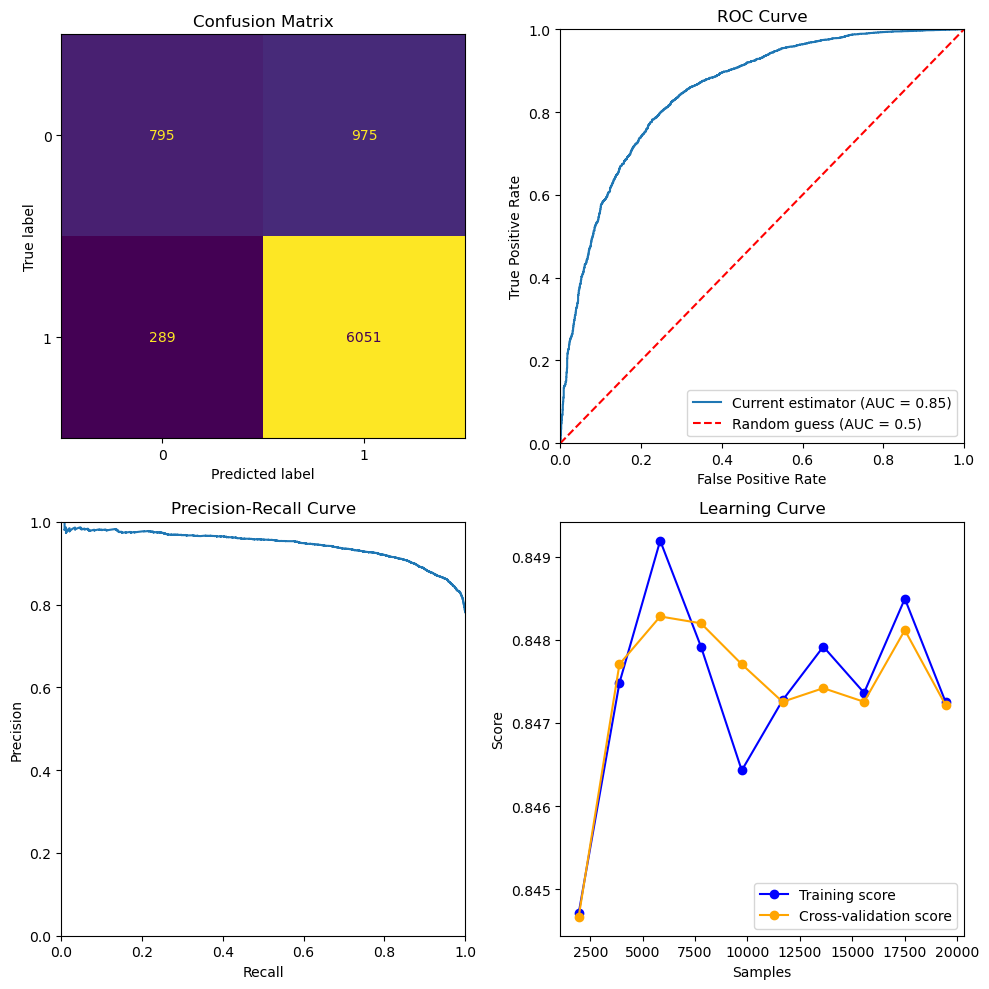

In [13]:
plot_graphs(best_log_model, X_train, X_test, y_train, y_test, cv=StratifiedKFold(n_splits=5))

## Decision Tree

### GridSearchCV

In [14]:
parameters = {
    'max_depth': [None, 5, 7, 10, 13, 15, 20],
    'min_samples_split': [1, 2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': [None, 'sqrt', 'log2']
}
decision_tree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(decision_tree, parameters, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

best_tree_model = grid_search.best_estimator_

print("Best parametrs:", grid_search.best_params_)

Best parametrs: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [15]:
y_pred_train = best_tree_model.predict(X_train)
y_pred_test = best_tree_model.predict(X_test)
best_tree_cv_scores = get_cv_scores(best_tree_model, X_train, y_train, cv=10)

print_metrics(y_train, y_pred_train, y_test, y_pred_test, best_tree_cv_scores)

,Test,Train,CV
accuracy,0.924044,0.935794,0.918530
precision,0.924755,0.928677,0.919543
recall,0.982808,0.994159,0.981636
F1,0.952898,0.960303,0.949566


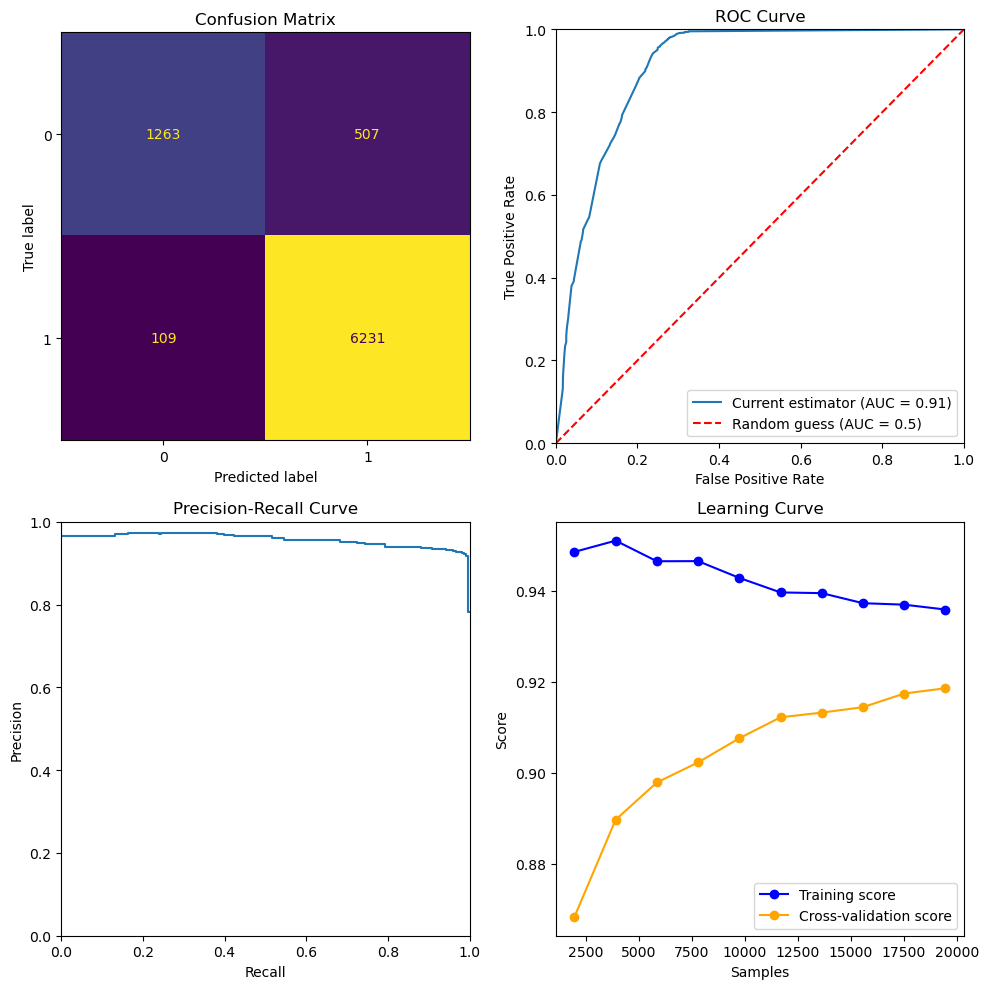

In [16]:
plot_graphs(best_tree_model, X_train, X_test, y_train, y_test, cv=StratifiedKFold(n_splits=5))

## Random Forest

In [17]:
forest_clf = RandomForestClassifier(n_estimators=600, max_depth=15, max_features=15, random_state=42)
forest_clf.fit(X_train, y_train)

y_pred_train = forest_clf.predict(X_train)
y_pred_test = forest_clf.predict(X_test)
forest_cv_scores = get_cv_scores(forest_clf, X_train, y_train, cv=5)

In [18]:
print_metrics(y_train, y_pred_train, y_test, y_pred_test, forest_cv_scores)

,Test,Train,CV
accuracy,0.934032,0.963088,0.927244
precision,0.928920,0.954925,0.922492
recall,0.991483,0.999947,0.990055
F1,0.959182,0.976918,0.955078


## Gradient boosting

### GridSearch

In [19]:
parameters = {
    'n_estimators': [10, 13, 15, 20, 25, 35, 50],
    'max_depth': [3, 5, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
}
gbm = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gbm, parameters, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

best_gbm_model = grid_search.best_estimator_

print("Best parametrs:", grid_search.best_params_)

Best parametrs: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50}


In [20]:
y_pred_train = best_gbm_model.predict(X_train)
y_pred_test = best_gbm_model.predict(X_test)
best_gbm_cv_scores = get_cv_scores(best_gbm_model, X_train, y_train, cv=10)

print_metrics(y_train, y_pred_train, y_test, y_pred_test, best_tree_cv_scores)

,Test,Train,CV
accuracy,0.932676,0.968144,0.918530
precision,0.931230,0.961050,0.919543
recall,0.986751,0.999737,0.981636
F1,0.958187,0.980012,0.949566


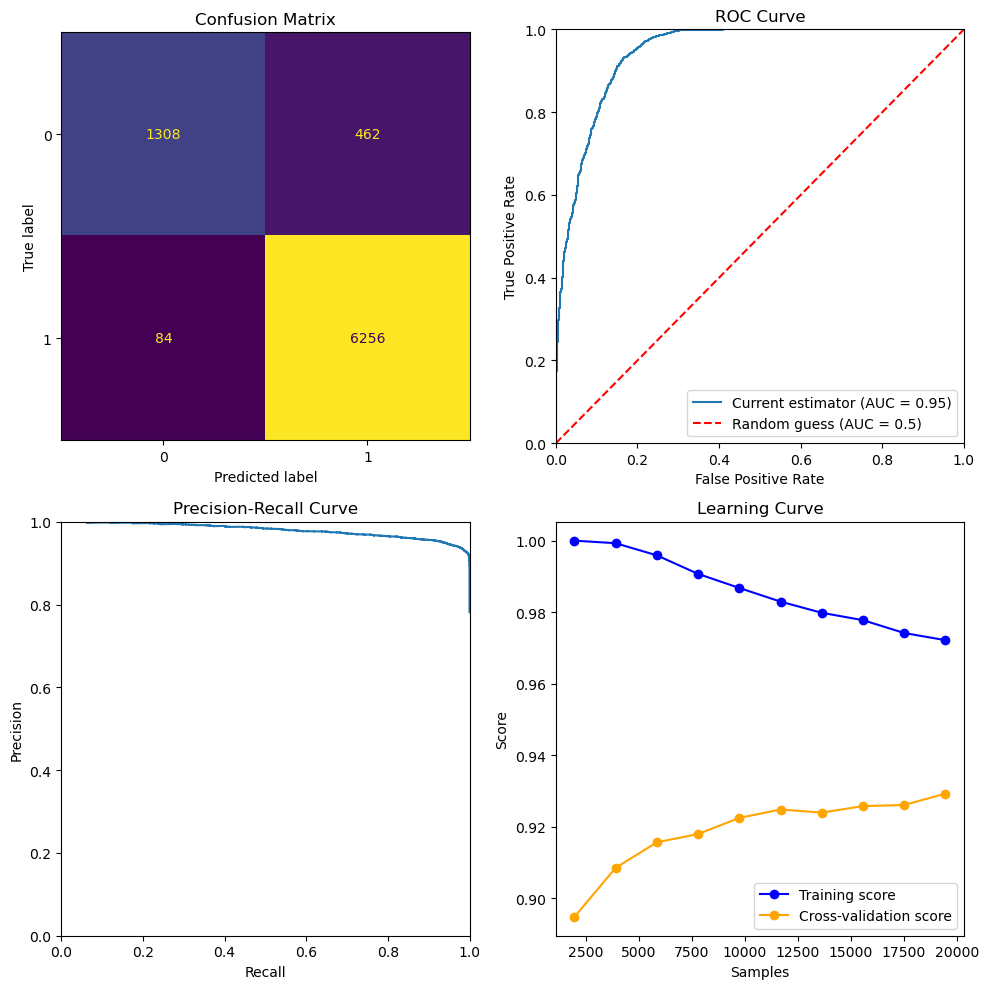

In [21]:
plot_graphs(best_gbm_model, X_train, X_test, y_train, y_test, cv=StratifiedKFold(n_splits=5))

# Summing

In [22]:
resource_path = './../application/resources/'

In [23]:
sm = get_summing_metrics({'Logistic regression': best_log_cv_scores, 'Decision tree': best_tree_cv_scores, 'Random forest': forest_cv_scores, 'Gradient boosting machines': best_gbm_cv_scores})
sm

,Logistic regression,Decision tree,Random forest,Gradient boosting machines
accuracy,0.847213,0.918530,0.927244,0.929341
precision,0.863309,0.919543,0.922492,0.926716
recall,0.955746,0.981636,0.990055,0.987687
f1,0.907175,0.949566,0.955078,0.956220


In [24]:
sm.to_json(resource_path + 'scores.json', orient='index')

# Saving models

In [25]:
joblib.dump(best_log_model, resource_path + 'Logistic regression.joblib')
joblib.dump(best_tree_model, resource_path + 'Decision tree.joblib')
joblib.dump(forest_clf, resource_path + 'Random forest.joblib')
joblib.dump(best_gbm_model, resource_path + 'Gradient boosting machines.joblib')

['./../application/resources/Gradient boosting machines.joblib']

# Saving weights

In [26]:
models_weights = {'Logistic regression': dict(zip(features, best_log_model.coef_.flatten())),
          'Random forest': dict(zip(features, forest_clf.feature_importances_)),
          'Gradient boosting machines': dict(zip(features, best_gbm_model.feature_importances_))}
with open(resource_path + 'weights.json', 'w') as json_file:
    json.dump(models_weights, json_file)